## Preprocess data

In [1]:
import pandas as pd
from mihm.data.process import multi_cat_to_one_hot, binary_to_one_hot, standardize_cols, convert_categorical_to_ordinal
from mihm.data.dataset import MIHMDataset

In [2]:
df = pd.read_stata('../HeatResilience.dta')
df.columns

Index(['pedlt1216', 'pedba1216', 'punem1216', 'pocmp1216', 'phpas1216',
       'pfvwc1216', 'ppv1216', 'mhval1216', 'mhinc1216', 'pmono', 'PNK_pct',
       'PBcell_pct', 'PCD8_Plus_pct', 'PCD4_Plus_pct', 'PNCD8_Plus_pct',
       'VBSI16WGTRA', 'age2016', 'female', 'racethn', 'mar2016', 'living2016',
       'eduy', 'work2016', 'chd2016', 'dep2016', 'adl2016', 'smoke2016',
       'bmi2016', 'psyche2016', 'stroke2016', 'hibpe2016', 'diabe2016',
       'hearte2016', 'drink2016', 'ltactx2016', 'mdactx2016', 'vgactx2016',
       'pm1yr', 'pm25_1', 'pm25_7', 'pm25_30', 'urban', 'mar_cat2', 'tractdis',
       'tractaff', 'ihs_wealthf2016', 'zPCPhenoAge_acc', 'zPCHorvath1_acc',
       'zPCHorvath2_acc', 'zPCHannum_acc', 'zPCGrimAge_acc',
       'zDunedinPACE_acc', 'division', 'm_HeatIndex_7d', 'm_HeatIndex_30d',
       'm_HeatIndex_90d', 'm_HeatIndex_1y', 'ch1_7d', 'ch1_30d', 'ch1_90d',
       'ch1_1y', 'ch2_7d', 'ch2_30d', 'ch2_90d', 'ch2_1y', 'resi_HI7d',
       'resi_Hlv17d'],
      dtype='o

In [3]:
# read model and rename cols
read_cols = ["zPCPhenoAge_acc", "m_HeatIndex_7d", "age2016", "female", "racethn", "eduy", "ihs_wealthf2016", "pmono", "PNK_pct", 
            "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",
            "smoke2016", "drink2016", "bmi2016", "tractdis", "urban", "mar_cat2", "psyche2016", "stroke2016", "hibpe2016",
            "diabe2016", "hearte2016", "ltactx2016", "mdactx2016", "vgactx2016", "dep2016", "adl2016", 
            "living2016", "division"]

colname_dict = {
    "zPCPhenoAge_acc": "Pheno Age Accel.", 
    "m_HeatIndex_7d": "mean heat index over 7d", 
    "age2016": "age", 
    "female": "female", 
    "racethn": "race/ethnicity", 
    "eduy": "education (in years)", 
    "ihs_wealthf2016": "household wealth (ihs)", 
    "smoke2016": "smoking status", 
    "drink2016": "drinking status", 
    "bmi2016": "bmi", 
    "tractdis": "tract disadvantage", 
    "urban": "urbanicity", 
    "mar_cat2": "marital status", 
    "psyche2016": "psychiatric conditions", 
    "stroke2016": "stroke", 
    "hibpe2016": "hypertension",
    "diabe2016": "diabetes", 
    "hearte2016": "heart disease", 
    "ltactx2016": "light activity", 
    "mdactx2016": "moderate activity", 
    "vgactx2016": "vigorous activity", 
    "dep2016": "depressive symptoms", 
    "adl2016": "adl limitations", 
    "living2016": "living alone", 
    "division": "census division"
}

df = pd.read_stata('../HeatResilience.dta', columns=read_cols)
df_orig = df.copy()
df_orig.dropna(inplace=True)
df.rename(columns=colname_dict, inplace=True)

In [4]:
# define model input variables
interactor_col = "mean heat index over 7d"
outcome_col = "Pheno Age Accel."
controlled_cols = [
    'mean heat index over 7d',
    "pmono",
    "PNK_pct",
    "PBcell_pct",
    "PCD8_Plus_pct",
    "PCD4_Plus_pct",
    "PNCD8_Plus_pct",
]
interaction_predictors = ['female', 'education (in years)', 'household wealth (ihs)',
'smoking status', 'drinking status', 'bmi', 'tract disadvantage',
'marital status', 'psychiatric conditions', 'stroke', 'hypertension',
'diabetes', 'heart disease', 'light activity', 'moderate activity',
'vigorous activity', 'depressive symptoms', 'adl limitations',
'living alone', 'race/ethnicity_1. NHB',
'race/ethnicity_2. Hispanic', 'race/ethnicity_3. Others',
'urbanicity_2. suurban (code 2)', 'urbanicity_3. ex-urban',
'census division_Midwest', 'census division_South', 'census division_West']

In [5]:
# define variable types for preprocessing
categorical_cols = ['female', 'race/ethnicity', 'urbanicity', 'marital status', 'psychiatric conditions', 'stroke',
                    'hypertension', 'diabetes', 'heart disease', 'living alone', 'census division']
ordinal_cols = ['smoking status', 'drinking status', 'light activity', 'moderate activity', 'vigorous activity', 'adl limitations']
continuous_cols = ['education (in years)', 'household wealth (ihs)', 'age', 'bmi',
                   'tract disadvantage', 'depressive symptoms', 'adl limitations', 'mean heat index over 7d',
                    'pmono', "PNK_pct", "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct", "Pheno Age Accel."]

In [6]:
for c in categorical_cols:
    df[c] = df[c].astype("category")
binary_cats = [c for c in categorical_cols if df[c].nunique() <=2]
multi_cats = [c for c in categorical_cols if df[c].nunique() > 2]

In [7]:
# make dataset
heat_dataset = MIHMDataset(df, interactor_col, controlled_cols, interaction_predictors, outcome_col)

In [8]:
# preprocess data
preprocess_list = [(binary_cats, binary_to_one_hot), 
                   (multi_cats, multi_cat_to_one_hot), 
                   (ordinal_cols, convert_categorical_to_ordinal)]

standardize_list = [(continuous_cols+ordinal_cols, standardize_cols)]

heat_dataset.preprocess(preprocess_list, inplace=True)
heat_dataset.standardize(standardize_list, inplace=True)
heat_dataset.dropna(inplace=True)

In [9]:
print("Total number of samples: ", len(heat_dataset))

Total number of samples:  3325


In [10]:
print("Mean and std of standardized predictors: ", heat_dataset.mean_std_dict)

Mean and std of standardized predictors:  {'education (in years)': (12.883308270676691, 3.1342179862584296), 'household wealth (ihs)': (5.4090805, 8.371072), 'age': (70.04451127819549, 9.23433744595856), 'bmi': (28.84815, 6.218937), 'tract disadvantage': (-0.012159855, 0.94902503), 'depressive symptoms': (1.3756391, 1.9412107), 'adl limitations': (1.7095765070919703e-17, 0.9999999999999999), 'mean heat index over 7d': (74.170525, 18.664015), 'pmono': (8.56896240601504, 2.425775207038868), 'PNK_pct': (0.09263381460765885, 0.05817143127709421), 'PBcell_pct': (0.06956864196926095, 0.05356930770984166), 'PCD8_Plus_pct': (0.2503239019150917, 0.12165371343251581), 'PCD4_Plus_pct': (0.6766124278740906, 0.13978046436234295), 'PNCD8_Plus_pct': (0.22016338784150424, 0.15927694059686853), 'Pheno Age Accel.': (-0.014999974, 0.99856097), 'smoking status': (0.676390977443609, 0.6654162517744427), 'drinking status': (0.4592481203007519, 0.6107067477432152), 'light activity': (2.3615037593984964, 1.10

### Split data into train test validation set 

In [11]:
from mihm.data.trainutils import train_test_val_split
from torch.utils.data import DataLoader
import torch

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device="cpu"

In [13]:
train_idx, test_idx, val_idx = train_test_val_split(len(heat_dataset))
print("Train size: ", len(train_idx))
print("Test size: ", len(test_idx))
print("Val size: ", len(val_idx))

Train size:  1662
Test size:  831
Val size:  832


In [14]:
train_heat_dataset = heat_dataset.get_subset(train_idx)
test_heat_dataset = heat_dataset.get_subset(test_idx)
val_heat_dataset = heat_dataset.get_subset(val_idx)

In [15]:
# create dataset
train_dataset = train_heat_dataset.to_torch_dataset(device=device)
dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)

In [16]:
#dim reduction using PCA
interaction_vars_np = heat_dataset.df[heat_dataset.interaction_predictors].to_numpy()
k_dim = 20
U, S, V = torch.pca_lowrank(torch.from_numpy(interaction_vars_np), q=k_dim, center=False, niter=10)
V = V.to(torch.float32)
V.requires_grad = False

### Train

In [17]:
import torch.nn as nn
import torch.optim as optim
from mihm.model.mihm import MIHM
from mihm.model.custom_loss import var_adjusted_mse_loss

In [18]:
interaction_var_size = train_heat_dataset.interaction_predictors.__len__()
controlled_var_size = train_heat_dataset.controlled_predictors.__len__()
hidden_layer_sizes = [50, 10, 1]
model = MIHM(interaction_var_size, controlled_var_size, hidden_layer_sizes,
                svd=True, svd_matrix=V, k_dim=k_dim,
                include_interactor_bias=True, concatenate_interaction_vars=True, batch_norm=True, vae=True, device=device)
if device == "cuda":
    model.cuda()

In [19]:
torch.manual_seed(0)
mseLoss = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
epochs = 500

In [20]:
train_dataset_torch = train_heat_dataset.to_tensor(device=device)
test_dataset_torch = test_heat_dataset.to_tensor(device=device)
val_heat_dataset_torch = val_heat_dataset.to_tensor(device=device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, sample in enumerate(dataloader):
        optimizer.zero_grad()
        # forward pass
        if model.vae:
            predicted_epi = model(sample["interaction_predictors"], sample["interactor"], sample["controlled_predictors"])
        else:
            predicted_epi = model(sample["interaction_predictors"], sample["interactor"], sample["controlled_predictors"])
        label = torch.unsqueeze(sample["outcome"], 1)
        # loss = var_adjusted_mse_loss(predicted_epi, label, logvar, lambda_reg=0.1)
        loss = mseLoss(predicted_epi, label)
        # backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # print average loss for epoch
    epoch_loss = running_loss / len(dataloader)
    # evaluation on test set
    model.eval()
    with torch.no_grad():
        predicted_epi = model(test_dataset_torch["interaction_predictors"], test_dataset_torch["interactor"], test_dataset_torch["controlled_predictors"])
        predicted_epi_val = model(val_heat_dataset_torch["interaction_predictors"], val_heat_dataset_torch["interactor"], val_heat_dataset_torch["controlled_predictors"])
        loss_test = mseLoss(predicted_epi, torch.unsqueeze(test_dataset_torch["outcome"], 1))
        loss_val = mseLoss(predicted_epi_val, torch.unsqueeze(val_heat_dataset_torch["outcome"], 1))
    print("Epoch {}/{} done!; Training Loss: {}; Testing Loss: {}; Validation Loss: {}".format(epoch+1, epochs, epoch_loss, loss_test, loss_val))

Epoch 1/500 done!; Training Loss: 1.7715803384780884; Testing Loss: 1.5164905786514282; Validation Loss: 1.649416446685791
Epoch 2/500 done!; Training Loss: 1.6959035992622375; Testing Loss: 1.486251950263977; Validation Loss: 1.6133825778961182
Epoch 3/500 done!; Training Loss: 1.6194460988044739; Testing Loss: 1.4579545259475708; Validation Loss: 1.5794956684112549
Epoch 4/500 done!; Training Loss: 1.6378434598445892; Testing Loss: 1.4315234422683716; Validation Loss: 1.5476641654968262
Epoch 5/500 done!; Training Loss: 1.5685676038265228; Testing Loss: 1.4068166017532349; Validation Loss: 1.5177223682403564
Epoch 6/500 done!; Training Loss: 1.5457538664340973; Testing Loss: 1.3834738731384277; Validation Loss: 1.4893934726715088
Epoch 7/500 done!; Training Loss: 1.4613572657108307; Testing Loss: 1.3615463972091675; Validation Loss: 1.462699055671692
Epoch 8/500 done!; Training Loss: 1.498803198337555; Testing Loss: 1.3409579992294312; Validation Loss: 1.4374243021011353
Epoch 9/500 

In [21]:
heat_dataset.mean_std_dict

{'education (in years)': (12.883308270676691, 3.1342179862584296),
 'household wealth (ihs)': (5.4090805, 8.371072),
 'age': (70.04451127819549, 9.23433744595856),
 'bmi': (28.84815, 6.218937),
 'tract disadvantage': (-0.012159855, 0.94902503),
 'depressive symptoms': (1.3756391, 1.9412107),
 'adl limitations': (1.7095765070919703e-17, 0.9999999999999999),
 'mean heat index over 7d': (74.170525, 18.664015),
 'pmono': (8.56896240601504, 2.425775207038868),
 'PNK_pct': (0.09263381460765885, 0.05817143127709421),
 'PBcell_pct': (0.06956864196926095, 0.05356930770984166),
 'PCD8_Plus_pct': (0.2503239019150917, 0.12165371343251581),
 'PCD4_Plus_pct': (0.6766124278740906, 0.13978046436234295),
 'PNCD8_Plus_pct': (0.22016338784150424, 0.15927694059686853),
 'Pheno Age Accel.': (-0.014999974, 0.99856097),
 'smoking status': (0.676390977443609, 0.6654162517744427),
 'drinking status': (0.4592481203007519, 0.6107067477432152),
 'light activity': (2.3615037593984964, 1.1018353140678592),
 'modera

In [22]:
bias = model.interactor_bias.cpu().detach().numpy()*heat_dataset.mean_std_dict["mean heat index over 7d"][1] + heat_dataset.mean_std_dict["mean heat index over 7d"][0]
print("Interactor bias: {} ".format(bias))

Interactor bias: [[57.205826]] 


In [23]:
model_name = "Feb27_heat_model_with_heat_bias_vae_svd"
torch.save(model.state_dict(), "../checkpoints/{}.pth".format(model_name))

## Model prediction

In [24]:
from mihm.model.mihm import IndexPredictionModel
from mihm.model.modelutils import get_index_prediction_weights
import matplotlib.pyplot as plt

In [25]:
hidden_layer_sizes = [50, 10, 1]
interaction_var_size = train_heat_dataset.interaction_predictors.__len__()
model_index = IndexPredictionModel(interaction_var_size, hidden_layer_sizes, svd=True, svd_matrix=V.cuda(), k_dim=k_dim)
state_dict = torch.load('../checkpoints/{}.pth'.format(model_name))
index_model_index = get_index_prediction_weights(state_dict)
model_index.load_state_dict(index_model_index)
model_index.cuda().eval()

IndexPredictionModel(
  (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (layers): ModuleList(
    (0): Linear(in_features=20, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [26]:
# get all interaction vars from the dataset
all_interaction_vars_tensor = heat_dataset.to_tensor(device="cuda")["interaction_predictors"]
mean_predicted_index = model_index(all_interaction_vars_tensor)
all_resilience_index = mean_predicted_index.detach().cpu().numpy()

(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   2.,   1.,   2.,
          3.,   4.,   1.,   9.,  11.,  12.,   6.,  26.,  24.,  25.,  43.,
         56.,  75.,  75., 104., 106., 145., 174., 197., 191., 230., 233.,
        251., 257., 227., 202., 152., 137.,  97.,  90.,  59.,  26.,  24.,
         13.,  15.,   5.,   8.,   2.,   2.]),
 array([-0.04982996, -0.0481778 , -0.04652565, -0.0448735 , -0.04322134,
        -0.04156919, -0.03991704, -0.03826489, -0.03661273, -0.03496058,
        -0.03330843, -0.03165627, -0.03000412, -0.02835197, -0.02669981,
        -0.02504766, -0.02339551, -0.02174336, -0.0200912 , -0.01843905,
        -0.0167869 , -0.01513474, -0.01348259, -0.01183044, -0.01017828,
        -0.00852613, -0.00687398, -0.00522183, -0.00356967, -0.00191752,
        -0.00026537,  0.00138679,  0.00303894,  0.00469109,  0.00634325,
         0.0079954 ,  0.00964755,  0.0112997 ,  0.01295186,  0.01460401,
         0.01625616,  0.01790832,  0.01956047,  0.02121262,  0.02286478,
 

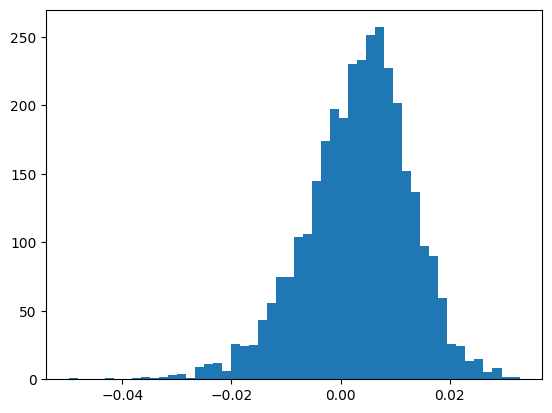

In [27]:
plt.hist(all_resilience_index, bins=50)

In [28]:
predicted_index, predicted_index_std = model_index.get_index_mean_std(all_interaction_vars_tensor)

(array([  7.,  26., 114., 264., 440., 439., 407., 302., 296., 216., 147.,
        122., 112.,  65.,  59.,  56.,  37.,  41.,  31.,  29.,  17.,  13.,
         18.,  12.,   6.,   8.,   5.,   2.,   5.,   4.,   2.,   5.,   1.,
          0.,   4.,   1.,   1.,   2.,   1.,   1.,   1.,   0.,   0.,   2.,
          0.,   1.,   0.,   0.,   0.,   3.]),
 array([ 35.70537186,  40.55595779,  45.40653992,  50.25712585,
         55.10771179,  59.95829773,  64.80888367,  69.6594696 ,
         74.51004791,  79.36063385,  84.21121979,  89.06180573,
         93.91239166,  98.7629776 , 103.61356354, 108.46414948,
        113.31472778, 118.16531372, 123.01589966, 127.8664856 ,
        132.71707153, 137.56765747, 142.41824341, 147.26882935,
        152.11941528, 156.97000122, 161.82058716, 166.67115784,
        171.52174377, 176.37232971, 181.22291565, 186.07350159,
        190.92408752, 195.77467346, 200.6252594 , 205.47584534,
        210.32643127, 215.17701721, 220.02760315, 224.87818909,
        229.728775

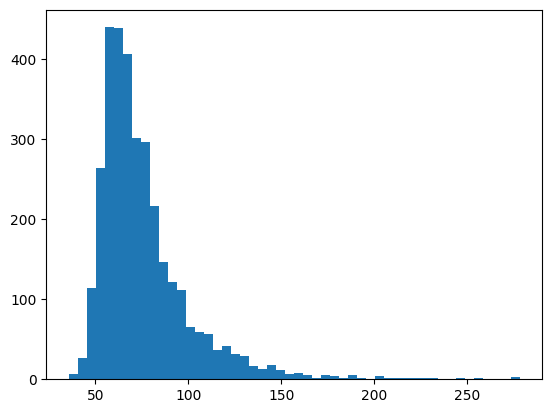

In [29]:
predicted_index_std = predicted_index_std.detach().cpu().numpy()
plt.hist(predicted_index_std, bins=50)

In [30]:
bias[0]

array([57.205826], dtype=float32)

In [31]:
df_orig.dropna(inplace=True)
df_orig["vul_index"] = all_resilience_index
# df_orig["m_HeatIndex_7d"] = df_orig["m_HeatIndex_7d"] - bias[0]
# df_orig["m_HeatIndex_7d"][df_orig["m_HeatIndex_7d"] < 0] = 0.0

In [32]:
df_orig.to_stata("../data/HeatResilience_with_vul_index_model_{}.dta".format(model_name), write_index=False)

## Confirm significance using linear regression on Stata

In [1]:
import stata_setup
stata_setup.config("/usr/local/stata17", "se")
from pystata import stata
import pandas as pd


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user  perpetual
Serial number: 501706323511
  Licensed to: Eunyoung Choi
               University of Southern California

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000 but can be increased;
          see help set_maxvar.


In [2]:
%%stata
use "../data/HeatResilience_with_vul_index_model_Feb27_heat_model_with_heat_bias_vae_svd.dta", clear

In [3]:
corr_cmd = "pwcorr vul_index tractdis urban ltactx2016 living2016 m_HeatIndex_7d zPCPhenoAge_acc age2016 female eduy ihs_wealthf2016 dep2016 adl2016 stroke2016 hibpe2016 diabe2016 hearte2016"
stata.run(corr_cmd, quietly=True)
out = stata.get_return()
corr_mat = out["r(C)"]

In [4]:
out.keys()

dict_keys(['r(N)', 'r(rho)', 'r(Nobs)', 'r(C)'])

In [5]:
corr_mat = out["r(C)"]

In [6]:
df_orig.columns

NameError: name 'df_orig' is not defined

In [7]:
# regress_cmd = "regress zPCPhenoAge_acc m_HeatIndex_7d age2016 i.female i.racethn eduy ihs_wealthf2016 pmono PNK_pct PBcell_pct PCD8_Plus_pct PCD4_Plus_pct PNCD8_Plus_pct smoke2016 i.drink2016 bmi2016 tractdis i.urban i.mar_cat2 psyche2016 stroke2016 hibpe2016 diabe2016 hearte2016 i.ltactx2016 i.mdactx2016 i.vgactx2016 dep2016 adl2016 i.living2016 i.division c.m_HeatIndex_7d#c.vul_index"
regress_cmd_2 = "regress zPCPhenoAge_acc m_HeatIndex_7d c.m_HeatIndex_7d#c.vul_index pmono PNK_pct PBcell_pct PCD8_Plus_pct PCD4_Plus_pct PNCD8_Plus_pct age2016 i.female i.racethn eduy ihs_wealthf2016 i.smoke2016 i.drink2016 bmi2016 tractdis i.urban i.mar_cat2 i.psyche2016 i.stroke2016 i.hibpe2016 i.diabe2016 i.hearte2016 dep2016 ltactx2016 mdactx2016 vgactx2016 i.living2016 i.division adl2016"
stata.run(regress_cmd_2)
out = stata.get_return()


      Source |       SS           df       MS      Number of obs   =     3,325
-------------+----------------------------------   F(38, 3286)     =     23.13
       Model |  699.419101        38  18.4057658   Prob > F        =    0.0000
    Residual |  2615.02126     3,286  .795806834   R-squared       =    0.2110
-------------+----------------------------------   Adj R-squared   =    0.2019
       Total |  3314.44036     3,324  .997124055   Root MSE        =    .89208



------------------------------------------------------------------------------
zPCPhenoAg~c | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
m_HeatInd~7d |   .0036362   .0009586     3.79   0.000     .0017566    .0055157
             |
          c. |
m_HeatInd~7d#|
 c.vul_index |   .0592093   .0371476     1.59   0.111    -.0136255    .1320441
             |
       pmono |  -.0138818   .0067564    -2.05   0.040    -.0271291   -.0006346
     PNK_pct |   .6182507   .2803407     2.21   0.027     .0685905    1.167911
  PBcell_pct |    .679266   .3071286     2.21   0.027     .0770831    1.281449
PCD8_Plus_~t |  -.1551961   .3691376    -0.42   0.674    -.8789591    .5685669
PCD4_Plus_~t |  -.5969625   .3282408    -1.82   0.069     -1.24054    .0466146
PNCD8_Plus~t |  -.6481633   .1267746    -5.11   0.000    -.8967284   -.3995981
     age2016 |  -.0093924   .0022235    -4.22   0.000     -.013752   -.

In [106]:
sig = out['r(table)'][3, 1]
print(sig)

0.11105646724613295


In [75]:
stata.run("vif", quietly=True)
out = stata.get_return()

In [77]:
vif_heat = out['r(vif_1)']
vif_inter = out['r(vif_2)']
print("vif_heat: {}, vif_interaction: {}".format(vif_heat, vif_inter))

vif_heat: 1.334439754486084, vif_interaction: 2.891094923019409


In [79]:
margins_cmd = "margins, at(m_HeatIndex_7d =(10(10)110) vul_index=(-0.25(0.3)0.35) ) atmeans"
margins_plt_cmd = 'marginsplot, level(83.4) xtitle("Mean Heat Index Lagged 7days") ytitle("Predicted PCPhenoAge Accl")'

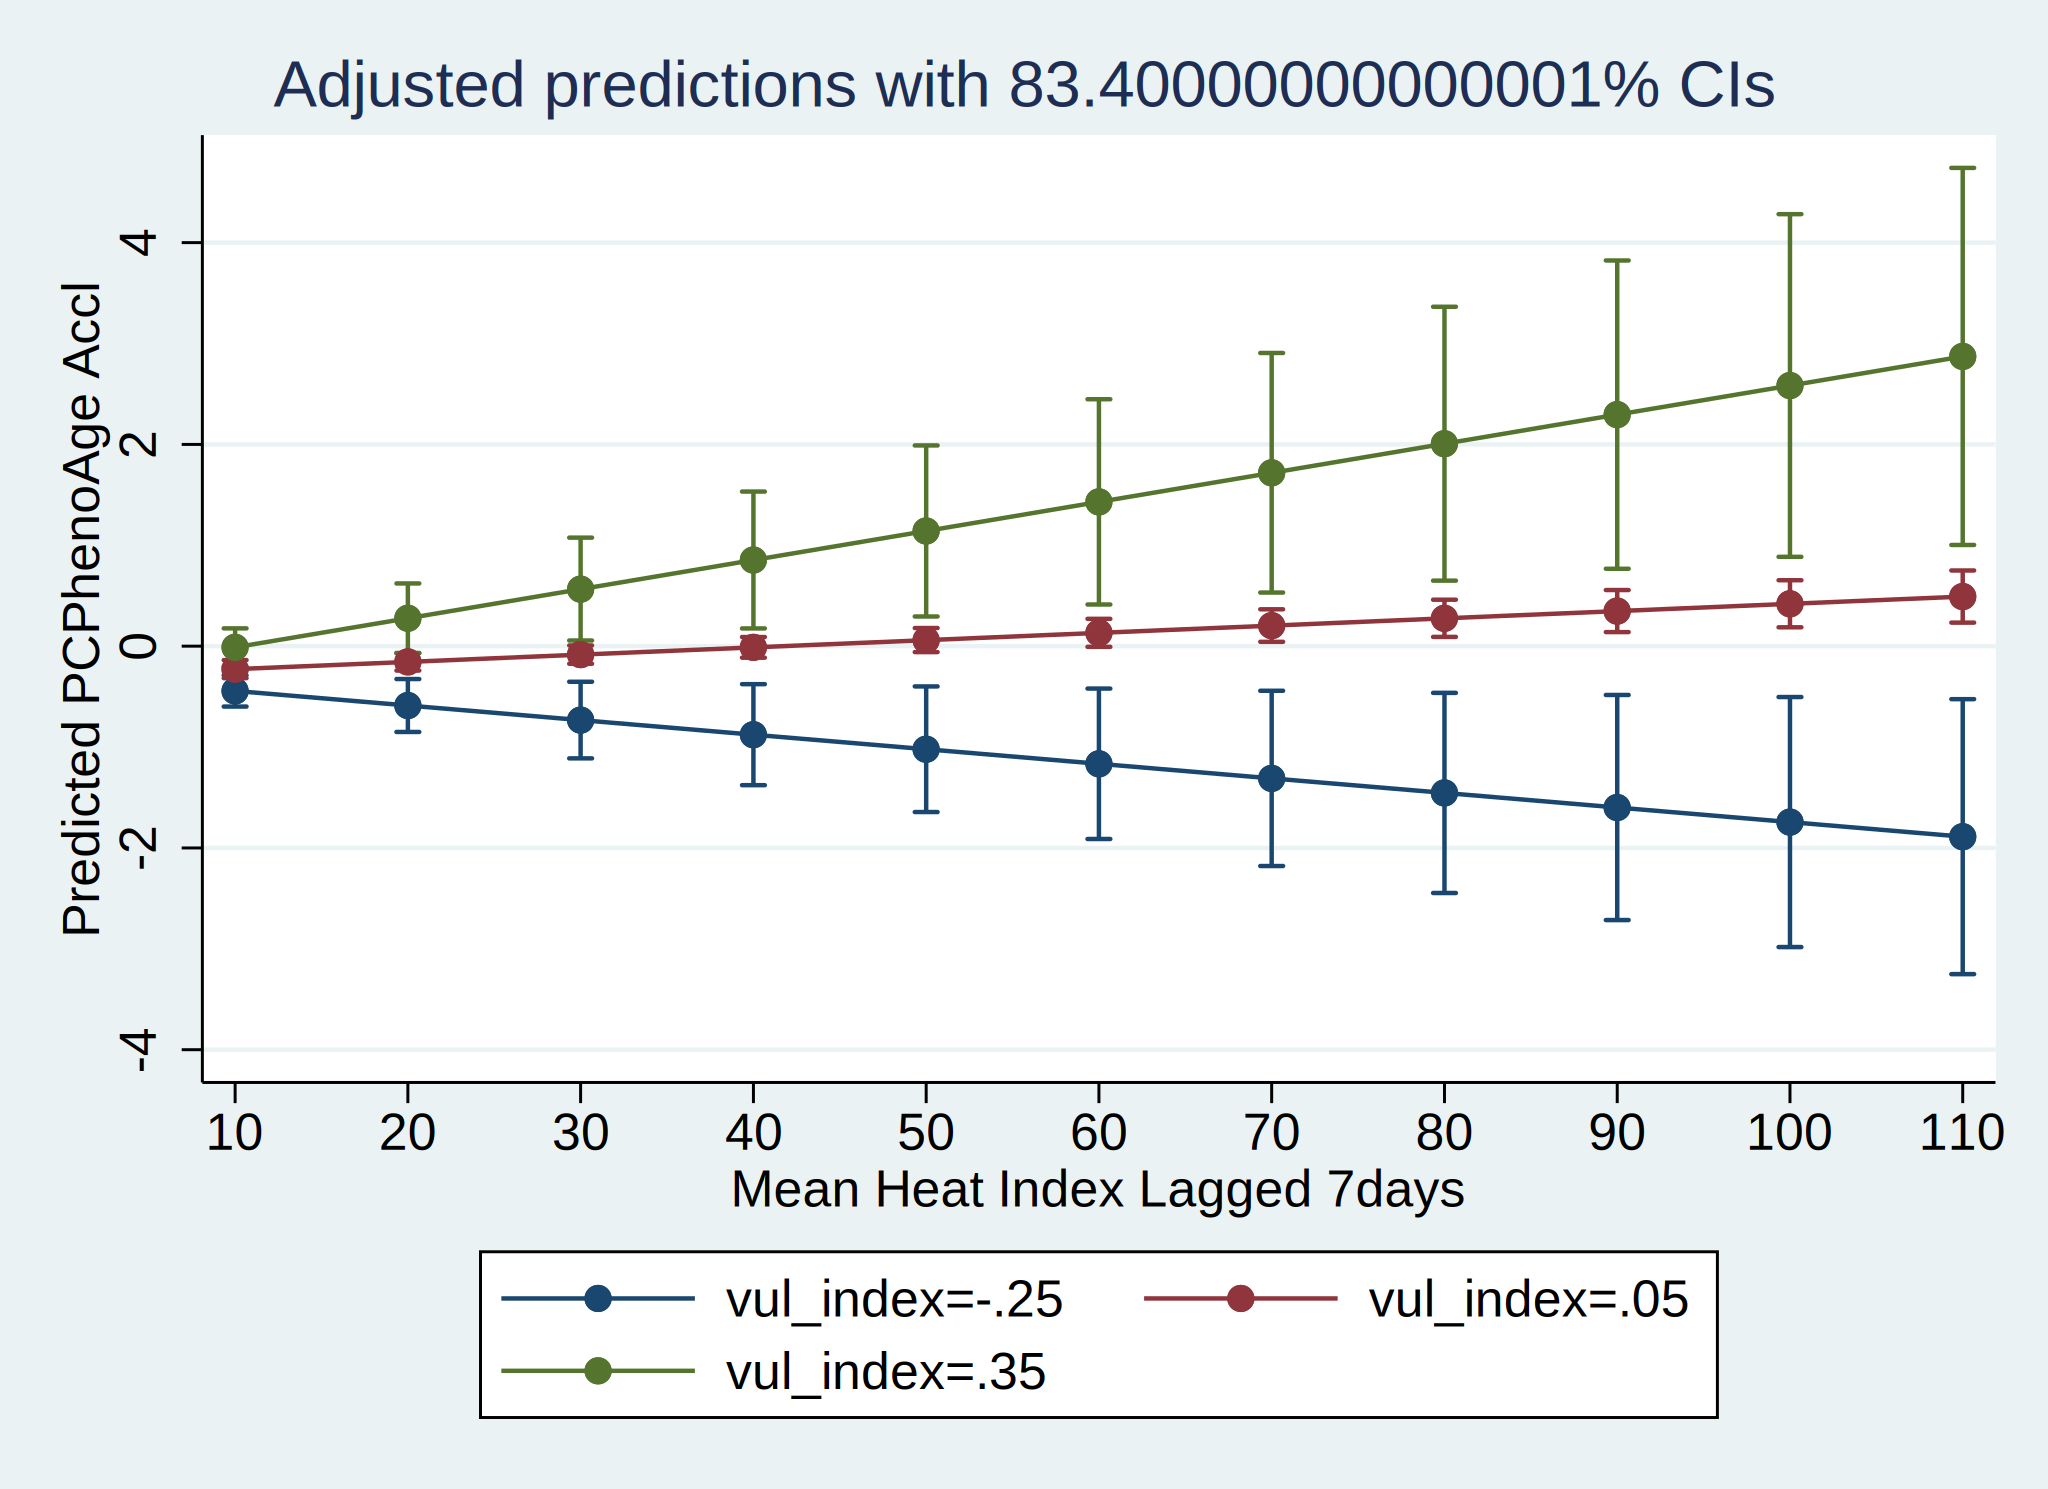

In [88]:
stata.run(margins_cmd, quietly=True)
stata.run(margins_plt_cmd, quietly=True)
stata.run('graph export my_figure.png, replace', quietly=True)  # Save the figure

## Model Analysis using Shapley values

In [8]:
import shap
import matplotlib.pyplot as plt
shap.initjs()

In [9]:
explainer = shap.DeepExplainer(model_index, all_interaction_vars_tensor)

NameError: name 'model_index' is not defined

In [40]:
shap_values = explainer.shap_values(all_interaction_vars_tensor[:1000], check_additivity=False)

In [15]:
shap.summary_plot(shap_values[:, :], all_interaction_vars_tensor[:1000, :].detach().cpu().numpy(), feature_names=interaction_predictors, show=False)
plt.savefig("../figures/{}_vae_svd_3.png".format(model_name), dpi=300, bbox_inches="tight")

NameError: name 'all_interaction_vars_tensor' is not defined

In [42]:
model_index.output_std = True
explainer = shap.DeepExplainer(model_index, all_interaction_vars_tensor)
shap_values_std = explainer.shap_values(all_interaction_vars_tensor[:1000], check_additivity=False)

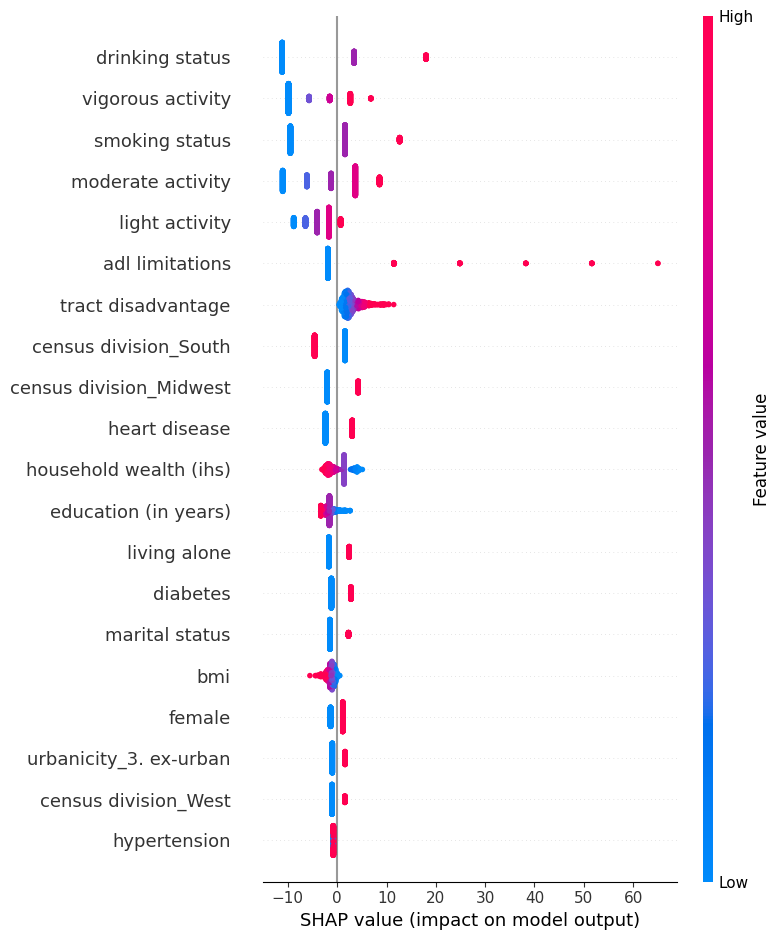

In [43]:
shap.summary_plot(shap_values_std[:, :], all_interaction_vars_tensor[:1000, :].detach().cpu().numpy(), feature_names=interaction_predictors, show=False)
plt.savefig("../figures/{}_vae_svd_3_std.png".format(model_name), dpi=300, bbox_inches="tight")